In [1]:
import fastf1
import pandas as pd
import numpy as np
import requests
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer

In [2]:
import os
import tempfile
# Use system temp directory for caching
cache_dir = os.path.join(tempfile.gettempdir(), "f1_cache")
os.makedirs(cache_dir, exist_ok=True)

fastf1.Cache.enable_cache(cache_dir)

In [3]:
# load the 2024 miami session data
session_2024 = fastf1.get_session(2024, "Miami", "R")
session_2024.load()
laps_2024 = session_2024.laps[["Driver", "LapTime", "Sector1Time", "Sector2Time", "Sector3Time"]].copy()
laps_2024.dropna(inplace=True)


core           INFO 	Loading data for Miami Grand Prix - Race [v3.6.0]
req            INFO 	No cached data found for session_info. Loading data...
_api           INFO 	Fetching session info data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for lap_count. Loading data...
_api           INFO 	Fetching lap count data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for track_status_data. Loading data...
_api           INFO 	Fetching track status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cach

In [8]:
laps_2024

,Driver,LapTime,Sector1Time,Sector2Time,Sector3Time,LapTime (s),Sector1Time (s),Sector2Time (s),Sector3Time (s)
1,VER,0 days 00:01:33.093000,0 days 00:00:31.455000,0 days 00:00:35.489000,0 days 00:00:26.149000,93.093,31.455,35.489,26.149
2,VER,0 days 00:01:33.137000,0 days 00:00:31.551000,0 days 00:00:35.472000,0 days 00:00:26.114000,93.137,31.551,35.472,26.114
3,VER,0 days 00:01:33.504000,0 days 00:00:31.508000,0 days 00:00:35.686000,0 days 00:00:26.310000,93.504,31.508,35.686,26.310
4,VER,0 days 00:01:32.834000,0 days 00:00:31.318000,0 days 00:00:35.410000,0 days 00:00:26.106000,92.834,31.318,35.410,26.106
5,VER,0 days 00:01:32.939000,0 days 00:00:31.528000,0 days 00:00:35.395000,0 days 00:00:26.016000,92.939,31.528,35.395,26.016
...,...,...,...,...,...,...,...,...,...
1106,PIA,0 days 00:01:32.610000,0 days 00:00:31.675000,0 days 00:00:35.281000,0 days 00:00:25.654000,92.610,31.675,35.281,25.654
1107,PIA,0 days 00:01:31.932000,0 days 00:00:31.311000,0 days 00:00:35.210000,0 days 00:00:25.411000,91.932,31.311,35.210,25.411
1108,PIA,0 days 00:01:31.665000,0 days 00:00:30.878000,0 days 00:00:35.143000,0 days 00:00:25.644000,91.665,30.878,35.143,25.644
1109,PIA,0 days 00:01:32.054000,0 days 00:00:31.051000,0 days 00:00:35.296000,0 days 00:00:25.707000,92.054,31.051,35.296,25.707


In [5]:
 #convert lap and sector times to seconds
for col in ["LapTime", "Sector1Time", "Sector2Time", "Sector3Time"]:
    laps_2024[f"{col} (s)"] = laps_2024[col].dt.total_seconds()


In [10]:
# aggregate sector times by driver
sector_times_2024 = laps_2024.groupby("Driver").agg({
    "Sector1Time (s)": "mean",
    "Sector2Time (s)": "mean",
    "Sector3Time (s)": "mean"
}).reset_index()

sector_times_2024["TotalSectorTime (s)"] = (
    sector_times_2024["Sector1Time (s)"] +
    sector_times_2024["Sector2Time (s)"] +
    sector_times_2024["Sector3Time (s)"]
)


In [11]:
# clean air race pace from racepace.py
clean_air_race_pace = {
    "VER": 93.191067, "HAM": 94.020622, "LEC": 93.418667, "NOR": 93.428600, "ALO": 94.784333,
    "PIA": 93.232111, "RUS": 93.833378, "SAI": 94.497444, "STR": 95.318250, "HUL": 95.345455,
    "OCO": 95.682128
}


In [12]:
# add quali data on Saturday for Miami GP 2025
qualifying_2025 = pd.DataFrame({
    "Driver": ["VER", "NOR", "PIA", "RUS", "SAI", "ALB", "LEC", "OCO",
               "TSU", "HAM", "STR", "GAS", "ALO", "HUL"],
    "QualifyingTime (s)": [86.204, 86.269, 86.375, 86.385, 86.569, 86.682,
                           86.754, 86.824, 86.943, 87.006, 87.830, 87.710, 87.604, 87.473]
})


In [13]:
qualifying_2025["CleanAirRacePace (s)"] = qualifying_2025["Driver"].map(clean_air_race_pace)


In [16]:
API_KEY = "d2585e28290357a9db05c428cdb49ae9"
weather_url = f"http://api.openweathermap.org/data/2.5/forecast?lat=25.7617&lon=-80.1918&appid={API_KEY}&units=metric"
response = requests.get(weather_url)
weather_data = response.json()
forecast_time = "2025-05-04 13:00:00"
forecast_data = next((f for f in weather_data["list"] if f["dt_txt"] == forecast_time), None)


In [17]:
rain_probability = forecast_data["pop"] if forecast_data else 0
temperature = forecast_data["main"]["temp"] if forecast_data else 20


In [18]:
# adjust qualifying time based on weather conditions
if rain_probability >= 0.75:
    qualifying_2025["QualifyingTime"] = qualifying_2025["QualifyingTime (s)"] * qualifying_2025["WetPerformanceFactor"]
else:
    qualifying_2025["QualifyingTime"] = qualifying_2025["QualifyingTime (s)"]


In [19]:
# add constructor's data
team_points = {
    "McLaren": 203, "Mercedes": 118, "Red Bull": 92, "Williams": 25, "Ferrari": 84,
    "Haas": 20, "Aston Martin": 14, "Kick Sauber": 6, "Racing Bulls": 8, "Alpine": 7
}

In [21]:
max_points = max(team_points.values())
team_performance_score = {team: points / max_points for team, points in team_points.items()}
team_performance_score


{'McLaren': 1.0,
 'Mercedes': 0.5812807881773399,
 'Red Bull': 0.45320197044334976,
 'Williams': 0.12315270935960591,
 'Ferrari': 0.41379310344827586,
 'Haas': 0.09852216748768473,
 'Aston Martin': 0.06896551724137931,
 'Kick Sauber': 0.029556650246305417,
 'Racing Bulls': 0.03940886699507389,
 'Alpine': 0.034482758620689655}

In [22]:
driver_to_team = {
    "VER": "Red Bull", "NOR": "McLaren", "PIA": "McLaren", "LEC": "Ferrari", "RUS": "Mercedes",
    "HAM": "Mercedes", "GAS": "Alpine", "ALO": "Aston Martin", "TSU": "Racing Bulls",
    "SAI": "Ferrari", "HUL": "Kick Sauber", "OCO": "Alpine", "STR": "Aston Martin"
}


In [23]:
qualifying_2025["Team"] = qualifying_2025["Driver"].map(driver_to_team)
qualifying_2025["TeamPerformanceScore"] = qualifying_2025["Team"].map(team_performance_score)

In [24]:
# merge qualifying and sector times data
merged_data = qualifying_2025.merge(sector_times_2024[["Driver", "TotalSectorTime (s)"]], on="Driver", how="left")
merged_data["RainProbability"] = rain_probability
merged_data["Temperature"] = temperature
merged_data["LastYearWinner"] = (merged_data["Driver"] == "VER").astype(int)
merged_data["QualifyingTime"] = merged_data["QualifyingTime"] ** 2

In [25]:
# define features (X) and target (y)
X = merged_data[[
    "QualifyingTime", "RainProbability", "Temperature", "TeamPerformanceScore", 
    "CleanAirRacePace (s)"
]]
y = laps_2024.groupby("Driver")["LapTime (s)"].mean().reindex(merged_data["Driver"])


In [26]:
# impute missing values for features
imputer = SimpleImputer(strategy="median")
X_imputed = imputer.fit_transform(X)

In [27]:
# train-test split
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.2, random_state=38)



In [28]:
# train gradient boosting model
model = GradientBoostingRegressor(n_estimators=300, learning_rate=0.05, max_depth=5, random_state=38)
model.fit(X_train, y_train)
merged_data["PredictedRaceTime (s)"] = model.predict(X_imputed)

In [29]:
# sort the results to find the predicted winner
final_results = merged_data.sort_values("PredictedRaceTime (s)")
print("\n🏁 Predicted 2025 Miami GP Winner 🏁\n")
print(final_results[["Driver", "PredictedRaceTime (s)"]])
y_pred = model.predict(X_test)
print(f"Model Error (MAE ): {mean_absolute_error(y_test, y_pred):.2f} seconds")


🏁 Predicted 2025 Miami GP Winner 🏁

   Driver  PredictedRaceTime (s)
1     NOR              94.442128
0     VER              94.693037
2     PIA              95.497146
4     SAI              95.786589
9     HAM              95.831018
8     TSU              95.982250
10    STR              96.024836
12    ALO              96.024836
6     LEC              96.029645
3     RUS              96.125678
7     OCO              96.176589
13    HUL              96.259036
11    GAS              96.276375
5     ALB              96.821589
Model Error (MAE ): 0.55 seconds


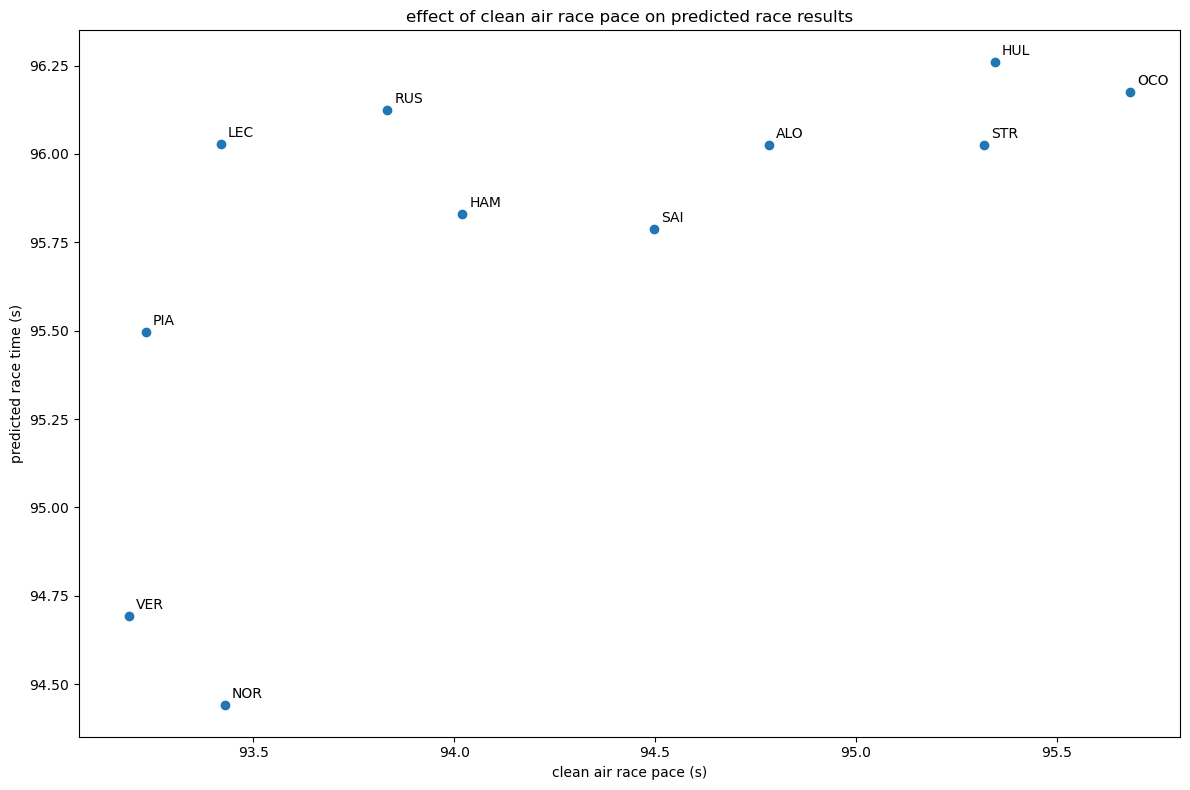

In [30]:
# plot effect of clean air race pace
plt.figure(figsize=(12, 8))
plt.scatter(final_results["CleanAirRacePace (s)"], final_results["PredictedRaceTime (s)"])
for i, driver in enumerate(final_results["Driver"]):
    plt.annotate(driver, (final_results["CleanAirRacePace (s)"].iloc[i], final_results["PredictedRaceTime (s)"].iloc[i]),
                 xytext=(5, 5), textcoords='offset points')
plt.xlabel("clean air race pace (s)")
plt.ylabel("predicted race time (s)")
plt.title("effect of clean air race pace on predicted race results")
plt.tight_layout()
plt.show()